In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections
import datetime

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ДЗ 4 (проект):

Вам будут даны 2 датафрейма: один с действиями пользователей в онлайн-кинотеатре (просмотр разного контента), другой - с информацией о пользователях (примерный возраст, пол, доход, наличие детей)

Допустим, мы хотим провести АВ-эксперимент с 1 по 14 августа.
Будем тестировать новую модель, которая, как мы полагаем будет воздействовать на всех пользователей (и тех, кто смотрит, и кто не смотрит)

Не смотрящие пользователи - те, у кого total_duration < 500

Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте

1. Перед тестом нам надо понять, какой MDE мы можем поймать на 2-х неделях (наше время ограничено), каким критерием будем пользоваться и какую метрику будем считать целевой. Поэтому проводим полноценный дизайн: 
    - выбираем целевую метрику (обычно это среднее время смотрения на юзера за период теста, но она высокодисперсионная, надо подумать, можно ли какую-то прокси метрику найти) (0.5 балла)
    - подбираем статистический критерий (и подробно объясняем, почему такой, а не другой) (1.5 балла)
    - исследуем метрику(и), как положено: проверяем надежность, чувствительность (0.5 балла)
    - определяем MDE, который можем поймать на 2-х неделях (1 балл)
    - находим (при необходимости) варианты увеличения чувствительности, исходя из особенностей метрики (2 балла)


    
2. А теперь представляем себе, что тест прошел:
    - разбивка была нашим обычным сплиттером, соль - 'kiontestmodel20210114', групп было 2
    - оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых активных пользователей
    
Пришло время оценить результаты.

Но для начала надо реализовать разбивку (0.5 балла) и подобрать вариант наложения эффекта, отвечающий нашему условию (1.5 балла)

Сделать выводы, что сработало хорошо, что плохо, почему (0.5 балла)

# Загрузка датасетов, EDA и предобработка

## Users

In [117]:
users = pd.read_csv('/content/drive/MyDrive/HW/users.csv')
users.head()

# user_id - уникальный идентификатор пользователя
# kids_flg = 0 - детей нет, если 1 - дети есть
# income - группа, в которую юзер отнесен по доходу
# age - группа, в которую юзер отнесен по возрасту
# sex - пол

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   840197 non-null  int64 
 1   age       826102 non-null  object
 2   income    825421 non-null  object
 3   sex       826366 non-null  object
 4   kids_flg  840197 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 32.1+ MB


In [ ]:
users.user_id.nunique()

840197

Все пользователи уникальные. Около 840 тысяч.

In [ ]:
print('{}% пропусков по возрасту совпадают с пропусками по доходу.'.format(
    round(users.query('income.isna() == True').age.isna().sum() / users.age.isna().sum() * 100, 2)
    ))

86.86% пропусков по возрасту совпадают с пропусками по доходу.


In [ ]:
print('{}% пропусков по полу совпадают с пропусками по доходу.'.format(
    round(users.query('income.isna() == True').sex.isna().sum() / users.sex.isna().sum() * 100, 2)
    ))

63.6% пропусков по полу совпадают с пропусками по доходу.


In [ ]:
print('{}% пропусков по полу совпадают с пропусками по возрасту и доходу.'.format(
    round(users.query('age.isna() == True & income.isna() == True').sex.isna().sum() / users.sex.isna().sum() * 100, 2)
    ))

60.83% пропусков по полу совпадают с пропусками по возрасту и доходу.


**Вывод:** Если придётся использовать эти данные для стратификации, бОльшая часть пропусков совпадает и мы не потеряем очень много объектов. С пропусками по полу меньше всего совпадений.

In [ ]:
users.age.value_counts()

age_25_34     233926
age_35_44     207043
age_45_54     135925
age_18_24     127672
age_55_64      75265
age_65_inf     46271
Name: age, dtype: int64

Все возрастные группы достаточно хорошо представлены. Все перекосы логичны. Ядро аудитории - 18-54. Жёсткое ядро - 25-44.

In [ ]:
users.sex.value_counts()

Ж    425270
М    401096
Name: sex, dtype: int64

Распределение по полу почти равное.

In [ ]:
users.kids_flg.mean()

0.30110557404989546

Только 30% аудитории с детьми. Есть подозрение, что все пропуски записаны как нули, потому что пропусков нет только в этом признаке и в `user_id`.

In [ ]:
users.income.value_counts()

income_20_40      471519
income_40_60      248330
income_60_90       68674
income_0_20        21836
income_90_150      13985
income_150_inf      1077
Name: income, dtype: int64

Основная часть аудитории обладает невысоким и средним доходом.

## Interactions

In [ ]:
interactions = pd.read_csv('/content/drive/MyDrive/HW/interactions.csv')
interactions.head()

# user_id - уникальный идентификатор пользователя
# item_id - уникальный идентификатор контента
# last_watch_dt - последняя дата просмотра юзером определенного контента
# total_dur - суммарная продолжительность просмотра определенного контента юзером (в секундах)
# watched_pct - процент просмотренного контента от общей продолжительности

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


Главный признак, на который мы будем ориентироваться, - **продолжительность просмотра**. Для удобства будем называть его **целевой метрикой**. В дальнейшем мы постепенно перейдём от продолжительности просмотра единицы контента к суммарному смотрению пользователя и к среднему смотрению пользователей за определённый период.

In [ ]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   item_id        int64  
 2   last_watch_dt  object 
 3   total_dur      int64  
 4   watched_pct    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 208.9+ MB


Всего около 5.5 миллионов взаимодействий.

In [ ]:
interactions.isna().sum()

user_id            0
item_id            0
last_watch_dt      0
total_dur          0
watched_pct      828
dtype: int64

В данных есть пропуски. Обработаем их чуть позже.

In [ ]:
# Проверим корректность числовых данных. Длительность не должна быть меньше 0, а процент просмотра должен быть от 0 до 100.

print(interactions.total_dur.min())
interactions.watched_pct.min(), interactions.watched_pct.max()

1


(0.0, 100.0)

In [ ]:
interactions.last_watch_dt.sort_values()

1863186    2021-03-13
3224846    2021-03-13
2162720    2021-03-13
3551672    2021-03-13
1299803    2021-03-13
              ...    
5250503    2021-08-22
2890284    2021-08-22
5168092    2021-08-22
179709     2021-08-22
714056     2021-08-22
Name: last_watch_dt, Length: 5476251, dtype: object

Предэкспериментальные данные собраны с марта по июль. Для дизайна 2-недельного эксперимента информации должно хватить.

In [ ]:
interactions.user_id.nunique()

962179

In [ ]:
interactions.user_id.nunique() / users.user_id.nunique()

1.1451826178860434

Уникальных пользователей в `interactions` в 1.145 раз больше, чем в `users`. Объединять таблицы надо осторожно.

### Обработка выбросов

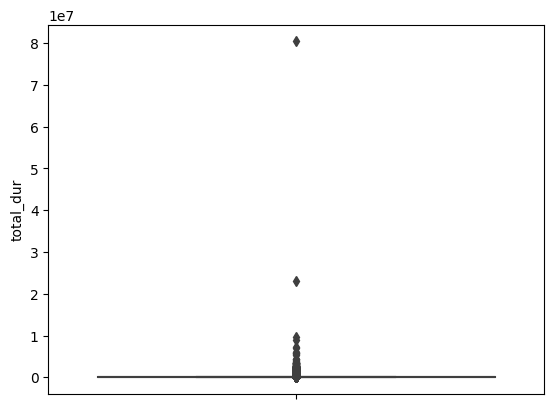

In [ ]:
sns.boxplot(data=interactions, y='total_dur');

Очевидно, в целевой метрике есть выбросы.

In [ ]:
interactions.total_dur.describe()

count    5.476251e+06
mean     8.295490e+03
std      4.856799e+04
min      1.000000e+00
25%      3.710000e+02
50%      2.898000e+03
75%      7.116000e+03
max      8.041167e+07
Name: total_dur, dtype: float64

Целевая метрика сейчас обладает сильной дисперсией, а максимальное значение на 4 разряда больше третьего квартиля.

Согласно заданию, эксперимент будет длиться 2 недели. Поэтому удалим все просмотры дольше 2 недель.

In [ ]:
print(interactions.query('total_dur > 14 * 24 * 60 * 60').shape[0])
print('{}%'.format(round(interactions.query('total_dur > 14 * 24 * 60 * 60').shape[0] / len(interactions) * 100, 2)))

504
0.01%


Таких всего 504, или одна сотая процента от всех данных.

In [ ]:
interactions = interactions.drop(interactions.query('total_dur > 14 * 24 * 60 * 60').index, axis=0)

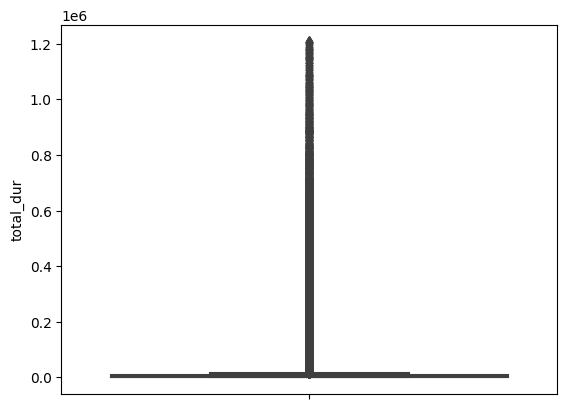

In [ ]:
sns.boxplot(data=interactions, y='total_dur');

Метрика всё равно несбалансированна, но других критериев для удаления выбросов по отдельным просмотрам у нас нет.

In [ ]:
interactions.total_dur.describe()

count    5.475747e+06
mean     8.112076e+03
std      2.673518e+04
min      1.000000e+00
25%      3.710000e+02
50%      2.897000e+03
75%      7.115000e+03
max      1.208365e+06
Name: total_dur, dtype: float64

Дисперсия сократилась в 1.8 раза, а максимальное значение потеряло один разряд.

### Обработка пропусков

In [ ]:
interactions.isna().sum()

user_id            0
item_id            0
last_watch_dt      0
total_dur          0
watched_pct      828
dtype: int64

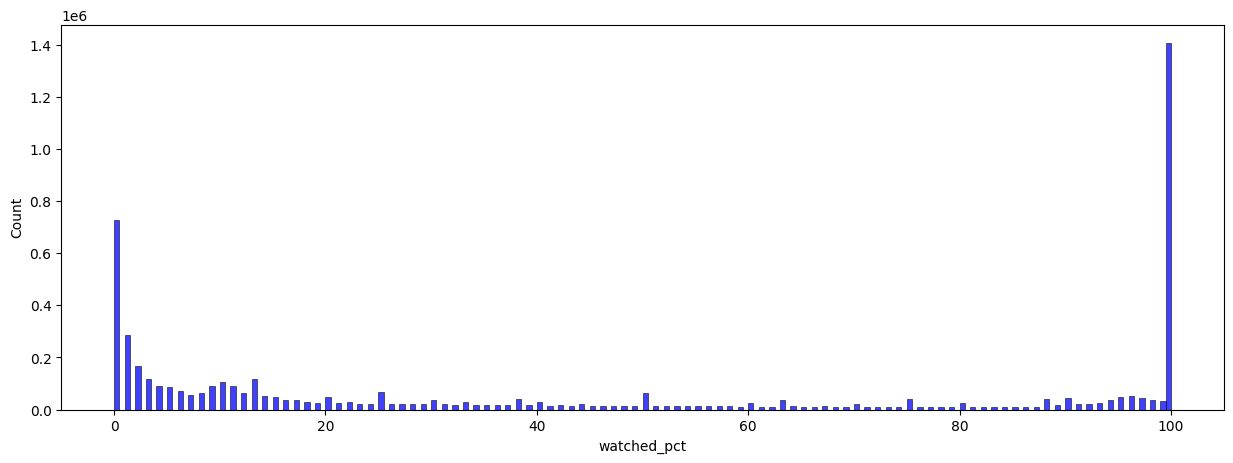

In [ ]:
# Запомним, как выглядит распределение watched_pct. Если мы всё сделаем правильно, оно не должно измениться.

fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data=interactions, x='watched_pct', bins=200, color='blue');

Заметим также большую долю 100% досмотров. А именно:

In [ ]:
interactions.query('watched_pct == 100').shape[0] / len(interactions)

0.25697315818280136

In [ ]:
# Запомним также квартили до обработки.

before_25 = interactions.watched_pct.quantile(0.25)
before_50 = interactions.watched_pct.quantile(0.5)
before_75 = interactions.watched_pct.quantile(0.75)

**Приступим.**

In [ ]:
interactions.query('watched_pct.isna() == True')

,user_id,item_id,last_watch_dt,total_dur,watched_pct
18473,296886,617,2021-06-29,1043,NaN
37129,1001166,2228,2021-04-20,215,NaN
42969,54778,9882,2021-08-04,314,NaN
51067,1059297,617,2021-07-13,8501,NaN
56856,571265,617,2021-07-07,2825,NaN
...,...,...,...,...,...
5453471,1003564,1130,2021-04-19,2,NaN
5460370,709070,617,2021-06-23,29,NaN
5461941,13284,13950,2021-04-18,136,NaN
5474507,1049024,174,2021-07-08,7560,NaN


Попробуем заполнить пропуски, исходя из информации о полной длительности соответствующего контента.

In [ ]:
interactions.query('item_id == 617').watched_pct.unique()

array([nan])

In [ ]:
interactions.query('item_id == 13950').watched_pct.unique()

array([nan])

Видимо, есть айтемы, для которых вообще не рассчитывается процент досмотра. Найдём их.

In [ ]:
# Составим список таких айтемов.

missed = interactions.query('watched_pct.isna() == True').item_id.unique()
missed_inter = interactions[interactions.item_id.isin(missed)]

In [ ]:
# Проверим, есть ли для них процент досмотра во всём датасете.

missed_inter.watched_pct.unique()

array([nan])

In [ ]:
len(missed)

101

101 айтем для нас - тёмные лошадки. Восстановим их watched_pct по перцентилям total_dur

In [ ]:
# Найдём перцентили метрики total_dur по айтемам из списка missed.

missed_stats = {}

for i in range(len(missed)):
    missed_quantiles = {}
    for j in np.arange(0, 1.01, 0.01):
        missed_quantiles[round(j, 2)] = missed_inter[missed_inter.item_id == missed[i]].total_dur.quantile(j)
    missed_stats[missed[i]] = missed_quantiles

In [ ]:
# Восстановим watched_pct согласно найденным перцентилям.

for i in tqdm(missed_stats):
    for j in missed_stats[i]:
        if j == 0:
            interactions.loc[interactions[
                (
                    (interactions['item_id'] == i) & 
                    (interactions['total_dur'] == missed_stats[i][j])
                )].index, 'watched_pct'] = j * 100
        elif j == 1:
            interactions.loc[interactions[
                (
                    (interactions['item_id'] == i) & 
                    (interactions['total_dur'] >= missed_stats[i][round(j - 0.01, 2)]) &
                    (interactions['total_dur'] <= missed_stats[i][j])
                )].index, 'watched_pct'] = j * 100
        else:
            interactions.loc[interactions[
                (
                    (interactions['item_id'] == i) & 
                    (interactions['total_dur'] >= missed_stats[i][round(j - 0.01, 2)]) &
                    (interactions['total_dur'] < missed_stats[i][j])
                )].index, 'watched_pct'] = j * 100

100%|██████████| 101/101 [13:12<00:00,  7.85s/it]


In [ ]:
interactions.isna().sum()

user_id          0
item_id          0
last_watch_dt    0
total_dur        0
watched_pct      0
dtype: int64

Теперь в датасете нет пропусков.

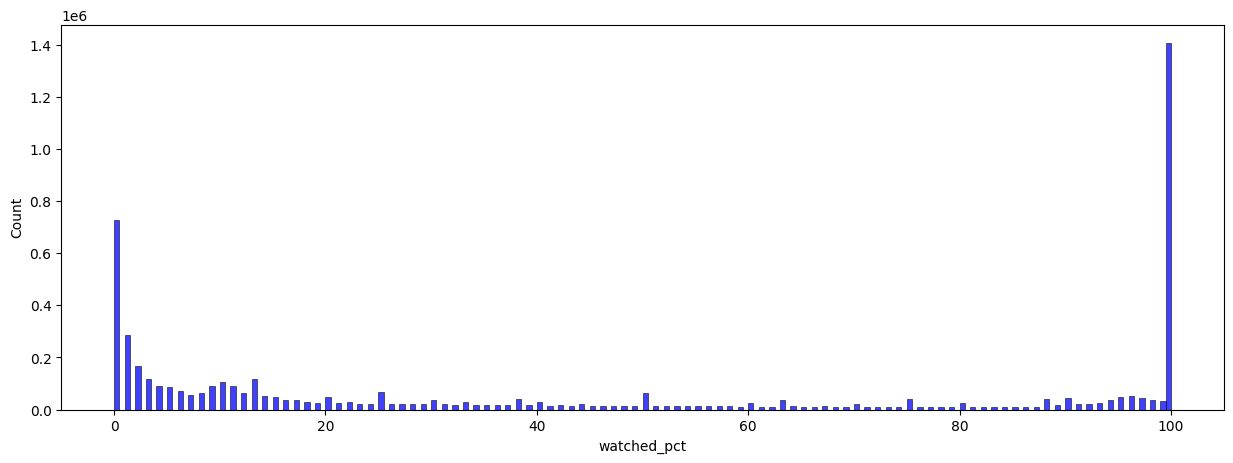

In [ ]:
# Проверим, что распределение watched_pct не изменилось.

fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data=interactions, x='watched_pct', bins=200, color='blue');

In [ ]:
# Сравним квартили до и после обработки.

print(before_25 == interactions.watched_pct.quantile(0.25))
print(before_50 == interactions.watched_pct.quantile(0.5))
print(before_75 == interactions.watched_pct.quantile(0.75))

True
True
True


In [ ]:
# Посмотрим на какой-нибудь айтем.

interactions.query('item_id == 617')

,user_id,item_id,last_watch_dt,total_dur,watched_pct
18473,296886,617,2021-06-29,1043,63.0
51067,1059297,617,2021-07-13,8501,80.0
56856,571265,617,2021-07-07,2825,71.0
63596,529068,617,2021-06-25,12,11.0
64131,621917,617,2021-07-05,19,16.0
...,...,...,...,...,...
5410192,1053855,617,2021-06-29,824,60.0
5425736,223362,617,2021-07-01,78144,93.0
5436026,363638,617,2021-06-30,7129,79.0
5460370,709070,617,2021-06-23,29,21.0


Вроде неплохо.

In [ ]:
# Посмотрим, как обработался айтем с одним просмотром.

interactions.query('item_id == 15554')

,user_id,item_id,last_watch_dt,total_dur,watched_pct
64751,618365,15554,2021-04-06,39,100.0


За неимением другой информации будем считать это 100%.

### Обнуление коротких просмотров.

In [ ]:
interactions.loc[interactions.query('total_dur < 500').index, ['total_dur', 'watched_pct']] = 0

In [ ]:
interactions.to_parquet('/content/drive/MyDrive/HW/interactions_02.parquet')
#interactions.to_csv('/content/drive/MyDrive/HW/interactions_02.csv')

In [ ]:
# Мы удаляли выбросы. Поэтому переиндексуем датасет.

interactions.reset_index(drop=True, inplace=True)

# Дизайн эксперимента

## Создание агрегированного датасета

In [3]:
interactions = pd.read_parquet('/content/drive/MyDrive/HW/interactions_02.parquet')
interactions.reset_index(drop=True, inplace=True)

Мы знаем, что эксперимент будет длиться 2 недели: с 01 по 14 августа. Допустим, сейчас 26 июля 2021 г. и у нас неделя на подготовку. Тогда период, за который у нас есть исторические данные, - 13.03.2021-25.07.2021. При этом у нас нет данных за предыдущие годы, чтобы на их основе выявить сезонность. Поэтому для дизайна возьмём самые свежие данные: **12.07-25.07**.

In [5]:
# Возьмём нужные 2 недели.

interactions.last_watch_dt = pd.to_datetime(interactions.last_watch_dt)

inter2 = interactions[(interactions.last_watch_dt >= pd.to_datetime('2021-07-12'))
              & (interactions.last_watch_dt <= pd.to_datetime('2021-07-25'))]

In [6]:
# Сагрегируем датасет и дропнем то, что не войдёт в агрегацию.

sim = inter2.drop(['last_watch_dt', 'item_id'], axis=1)

sim = sim.groupby('user_id', as_index=False).agg(
    quantity=('total_dur', 'count'),
    total_dur=('total_dur', np.sum),
    watched_pct=('watched_pct', np.mean))

sim.loc[sim.query('total_dur == 0').index, 'quantity'] = 0

In [7]:
sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219356 entries, 0 to 219355
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      219356 non-null  int64  
 1   quantity     219356 non-null  int64  
 2   total_dur    219356 non-null  int64  
 3   watched_pct  219356 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 6.7 MB


В симуляцию вошло 219356 уникальных пользователей.

In [8]:
print(sim.query('total_dur > 14 * 24 * 60 * 60').shape[0])
print('{}%'.format(round(sim.query('total_dur > 14 * 24 * 60 * 60').shape[0] / sim.shape[0] * 100, 2)))

14
0.01%


Из них 14, или 0.01% посмотрели суммарно за две недели больше двух недель. Дропнем их. 

In [9]:
sim = sim.drop(sim.query('total_dur > 14 * 24 * 60 * 60').index, axis=0)

## Обзор потенциальных метрик

### total_dur

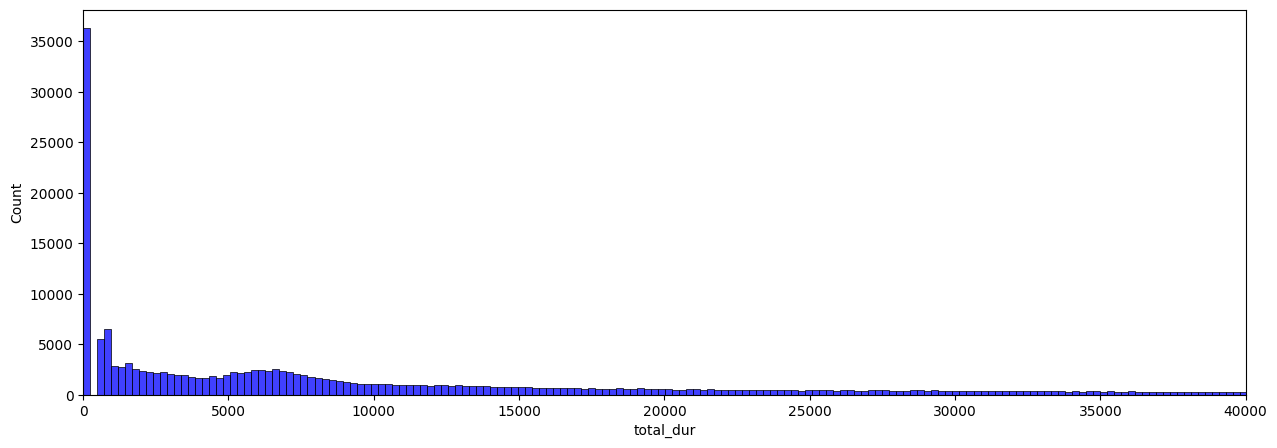

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlim(0, 40000)
sns.histplot(data=sim, x='total_dur', bins=5000, color='blue');

На гистограмме хорошо видно нулевые просмотры, гэп до 500 секунд и остальное распределение. Преобладает короткое смотрение, затем частоты идут на спад с некоторым подъёмом в районе 6000 секунд. Это соответствует продолжительности одного полнометражного фильма. Стоит ожидать большого числа единиц в `quantity`.

### quantity

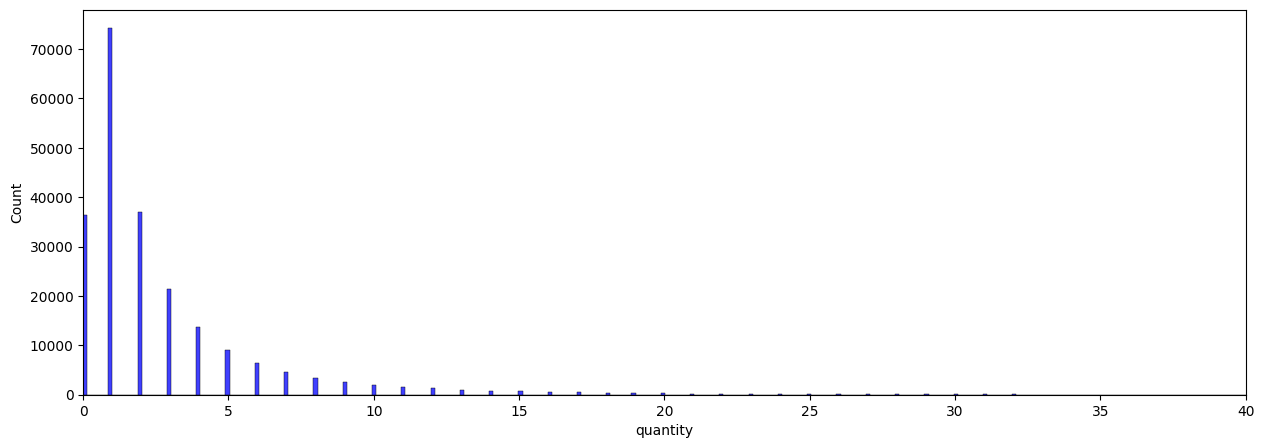

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlim(0, 40)
sns.histplot(data=sim, x='quantity', bins=1000, color='blue');

Большинство пользователей зашло 1 раз за две недели.

### watched_pct

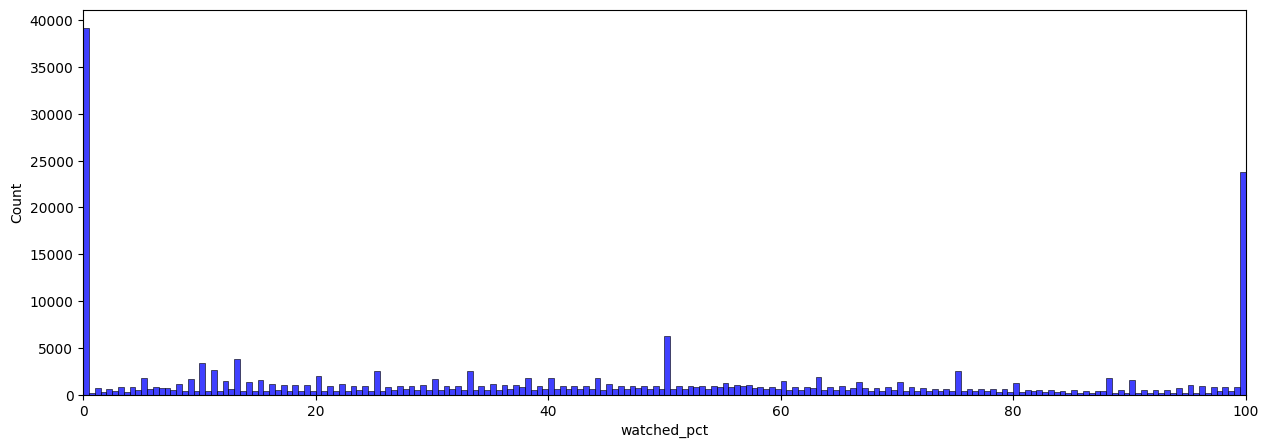

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlim(0, 100)
sns.histplot(data=sim, x='watched_pct', bins=200, color='blue');

`watched_pct` показывает, что многие пользователи, если смотрят контент, то до конца.

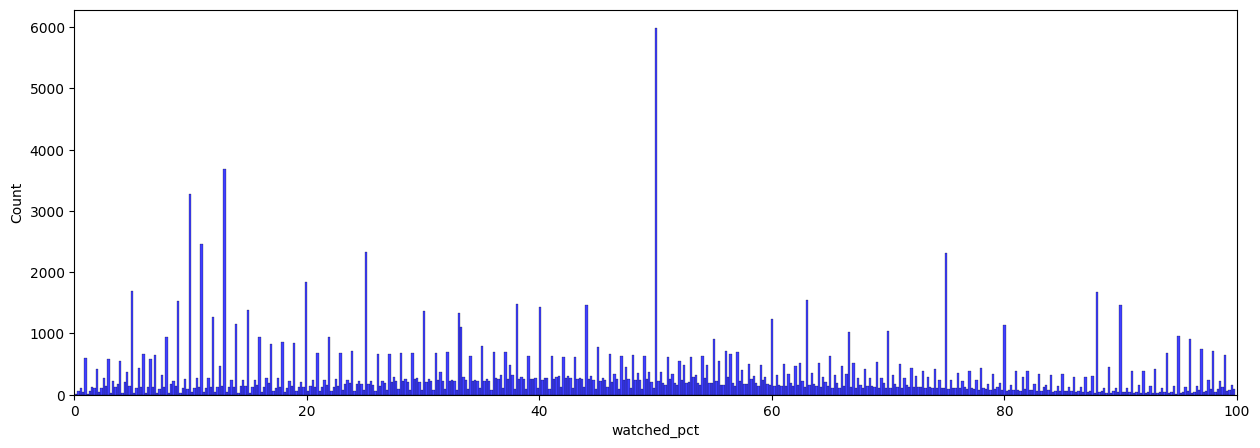

In [ ]:
# Остальные выглядят вот так.

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlim(0, 100)
sns.histplot(data=sim.query('0 < watched_pct < 100'), x='watched_pct', bins=500, color='blue');

Явная мода в 50%.

## Проверка метрик на ЦПТ

In [11]:
def test_CPT(a, alpha=0.05):
    
    normaltest_pv = stats.normaltest(a)[1]
    shapiro_pv = stats.shapiro(a)[1]
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    res = scipy.stats.probplot(a, dist='norm', plot=ax)
    plt.show()

    return {'normaltest': [normaltest_pv, normaltest_pv > alpha], 'shapiro': [shapiro_pv, shapiro_pv > alpha]}

In [12]:
def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))

def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

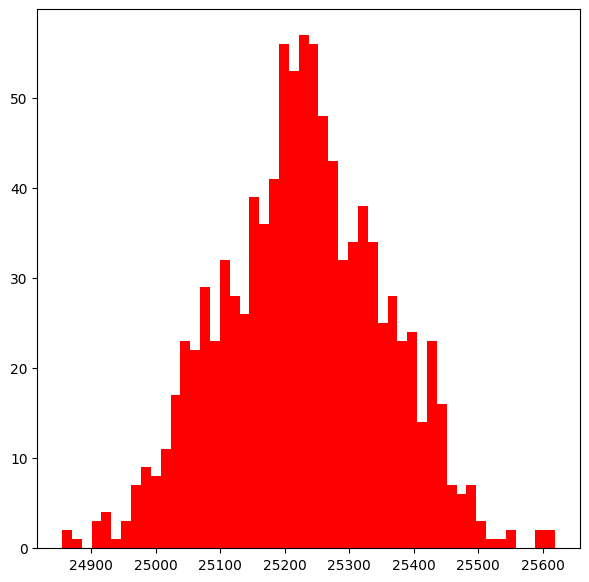

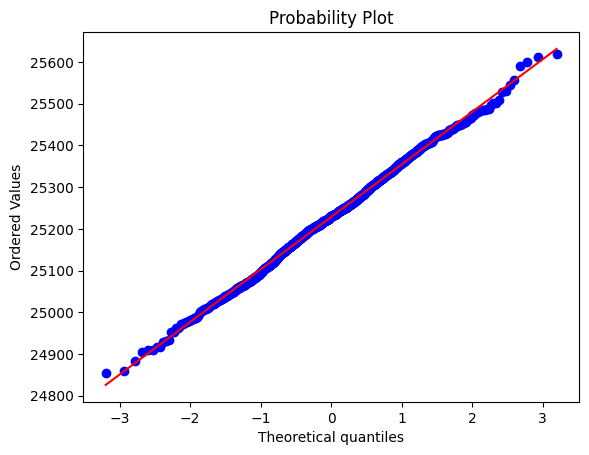

{'normaltest': [0.5954403248209799, True],
 'shapiro': [0.38321933150291443, True]}

In [ ]:
# total_dur

a = calc_bootstrap_mean(sim.total_dur, size=1000)

plt.figure(figsize=(7,7))
plt.hist(a, bins=50, color='red',  linewidth=2);
plt.show()

test_CPT(a, alpha=0.05)

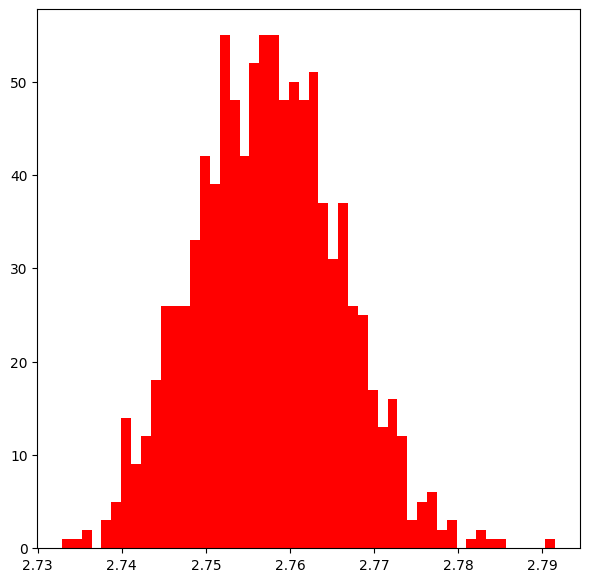

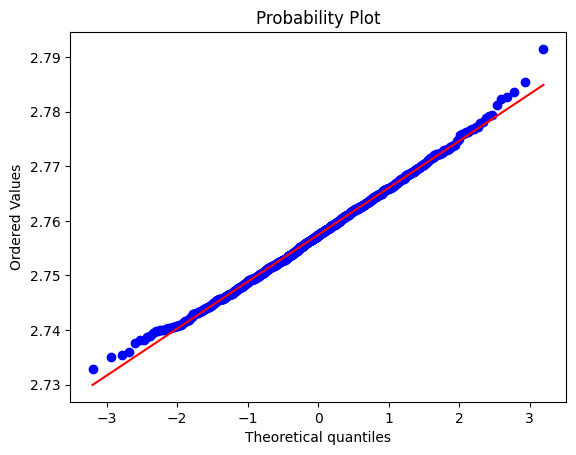

{'normaltest': [0.09484455874758371, True],
 'shapiro': [0.13371391594409943, True]}

In [15]:
# quantity

a = calc_bootstrap_mean(sim.quantity, size=1000)

plt.figure(figsize=(7,7))
plt.hist(a, bins=50, color='red',  linewidth=2);
plt.show()

test_CPT(a, alpha=0.05)

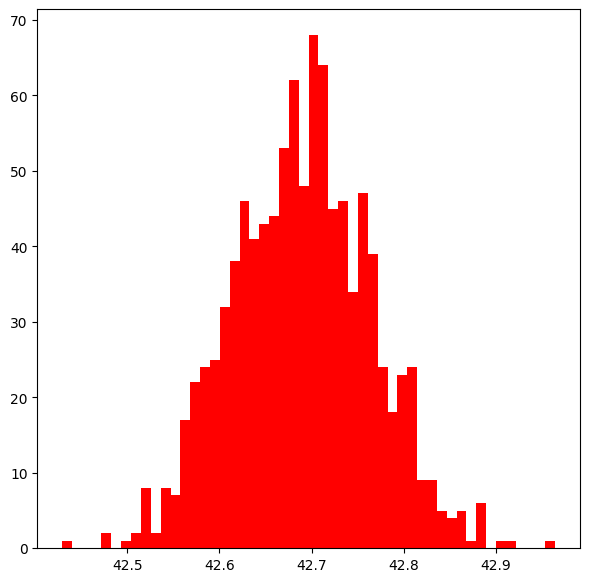

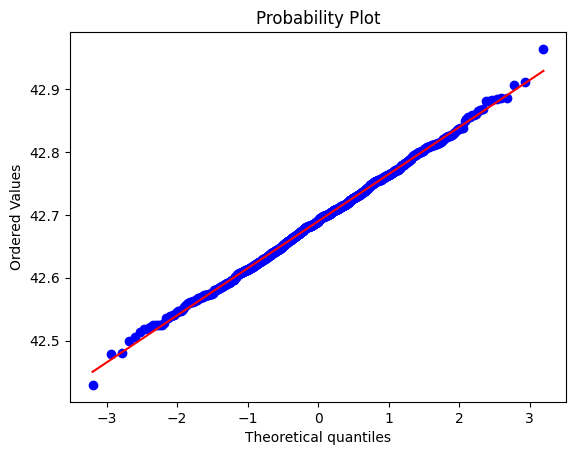

{'normaltest': [0.7695171117894353, True],
 'shapiro': [0.8573013544082642, True]}

In [16]:
# watched_pct

a = calc_bootstrap_mean(sim.watched_pct, size=1000)

plt.figure(figsize=(7,7))
plt.hist(a, bins=50, color='red',  linewidth=2);
plt.show()

test_CPT(a, alpha=0.05)

1. Все метрики чаще всего удовлетворяют ЦПТ на 1000 случайных величин. Значит, для них можно вычислить MDE и к ним можно применять параметрические тесты.

## Расчёт MDE метрик

In [17]:
def get_mde(metric, alpha=0.05, beta=0.2):
    
    metric_mean, metric_std, metric_n = metric.mean(), metric.std(), metric.shape[0]
    
    z_alpha = stats.norm.ppf(1-(alpha / 2), loc=0, scale=1)
    z_beta = stats.norm.ppf(1-beta, loc=0, scale=1)
    
    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)
    
    return mde*100/metric_mean

In [18]:
print('MDE total_dur =', get_mde(sim.total_dur, alpha=0.05, beta=0.2))
print('MDE quantity =', get_mde(sim.quantity, alpha=0.05, beta=0.2))
print('MDE watched_pct =', get_mde(sim.watched_pct, alpha=0.05, beta=0.2))

MDE total_dur = 1.3957049419055167
MDE quantity = 0.8747070573666043
MDE watched_pct = 0.48182133863333565


Все метрики на 2 неделях позволяют поймать достаточно малый эффект.

## Проверка мощности и корректности метрик на t-тесте с эффектом 1.02

In [10]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)
    
    return b64encode(salt).decode('ascii')

In [11]:
def groups_splitter(df, user_salt=None):
    
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt
    
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[['user_id', 'group']].drop_duplicates()

100%|██████████| 1000/1000 [11:44<00:00,  1.42it/s]


Effect = 1.97%


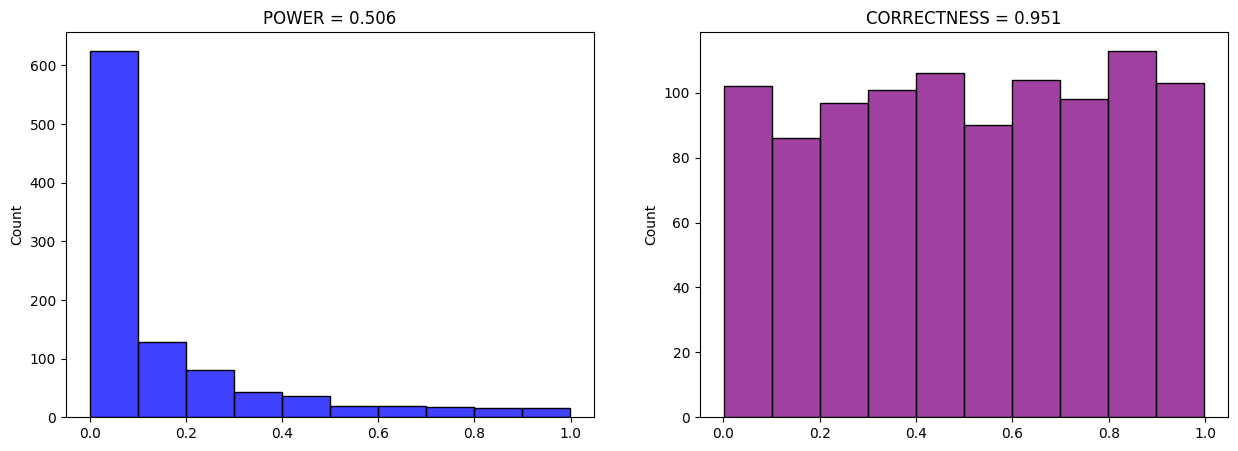

In [ ]:
# total_dur - t-тест

effect = []
power = []
correctness = []

for i in tqdm(range(1000)):
    
    groups = groups_splitter(sim.copy(), user_salt=salt_generator())
    df = pd.merge(sim, groups, how="left", on=['user_id']).drop_duplicates()
    
    a = df[df['group'] == 'A']['total_dur']
    b = df[df['group'] == 'B']['total_dur']
    b_effect = b * 1.02
    
    effect.append((b_effect.mean() - a.mean()) / a.mean())

    p_power, p_cor = stats.ttest_ind(a, b_effect)[1], stats.ttest_ind(a, b)[1]
    power.append(p_power)
    correctness.append(p_cor)
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')

100%|██████████| 1000/1000 [11:57<00:00,  1.39it/s]


Effect = 2.02%


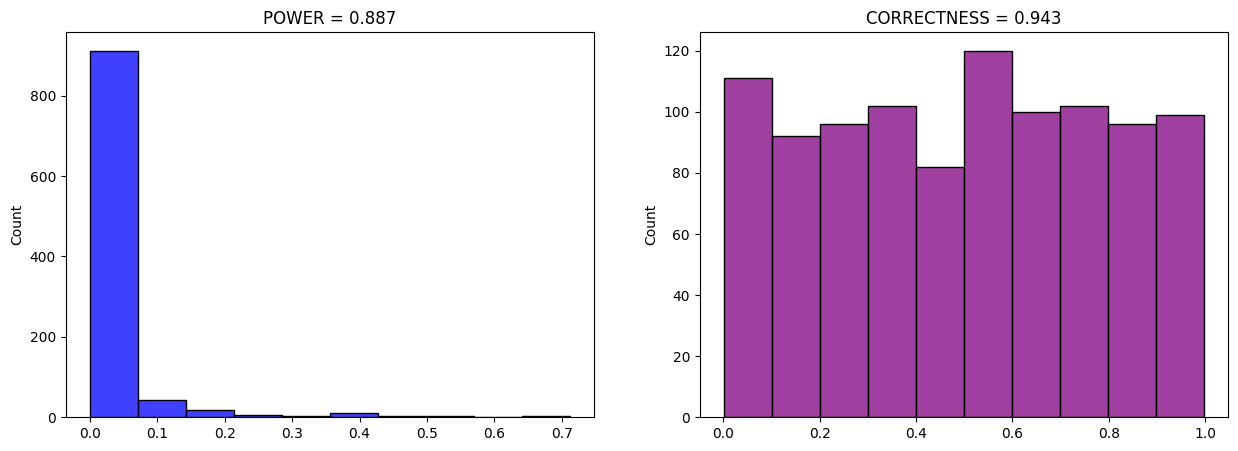

In [ ]:
# quantity - t-тест

effect = []
power = []
correctness = []

for i in tqdm(range(1000)):
    
    groups = groups_splitter(sim.copy(), user_salt=salt_generator())
    df = pd.merge(sim, groups, how="left", on=['user_id']).drop_duplicates()
    
    a = df[df['group'] == 'A']['quantity']
    b = df[df['group'] == 'B']['quantity']
    b_effect = b * 1.02
    
    effect.append((b_effect.mean() - a.mean()) / a.mean())

    p_power, p_cor = stats.ttest_ind(a, b_effect)[1], stats.ttest_ind(a, b)[1]
    power.append(p_power)
    correctness.append(p_cor)
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')

100%|██████████| 1000/1000 [17:23<00:00,  1.04s/it]


Effect = 2.01%


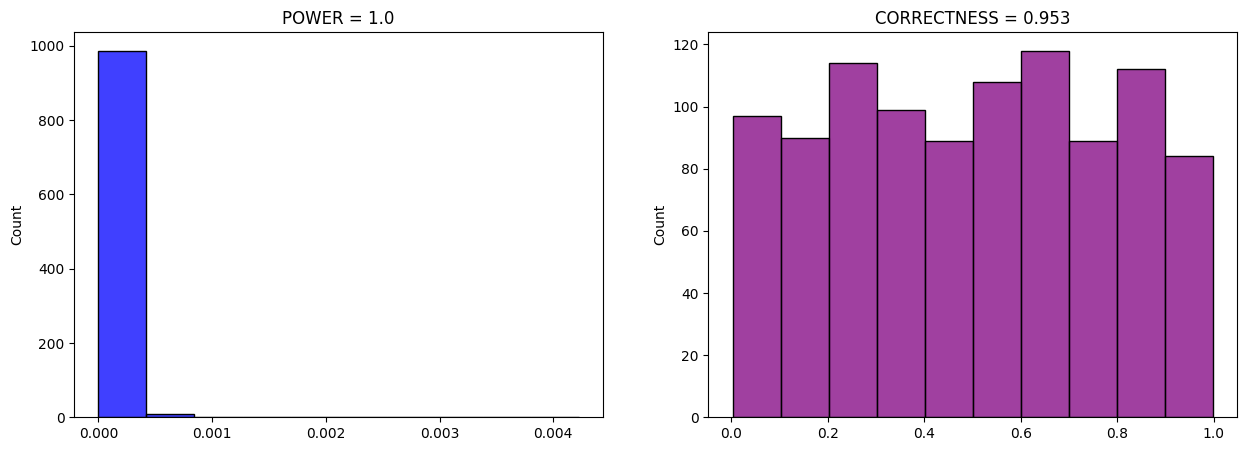

In [21]:
# watched_pct - t-тест

effect = []
power = []
correctness = []

for i in tqdm(range(1000)):
    
    groups = groups_splitter(sim.copy(), user_salt=salt_generator())
    df = pd.merge(sim, groups, how="left", on=['user_id']).drop_duplicates()
    
    a = df[df['group'] == 'A']['watched_pct']
    b = df[df['group'] == 'B']['watched_pct']
    b_effect = b * 1.02
    
    effect.append((b_effect.mean() - a.mean()) / a.mean())

    p_power, p_cor = stats.ttest_ind(a, b_effect)[1], stats.ttest_ind(a, b)[1]
    power.append(p_power)
    correctness.append(p_cor)
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')

**Выводы**
- В качестве метрики хотелось бы использовать `total_dur`. Но для этого её надо улучшить преобразованиями или использовать другие статистистические критерии.
- `quantity` уже сейчас показывает себя неплохо. Можно её поулучшать и использовать в качестве запасного варианта.
- `watched_pct` показывает мощность 100%, но использовать мы эту метрику будем только в крайнем случае.

## Повышение мощности и выбор метрик

### CUPED

In [22]:
# Возьмём все более ранние взаимодействия.

inter1 = interactions[interactions.last_watch_dt <= pd.to_datetime('2021-07-11')]

In [23]:
# Количество уникальных пользователей.

inter1.user_id.nunique()

646412

In [24]:
wanted_users = sim.user_id.unique()
print(inter1[inter1.user_id.isin(wanted_users)].user_id.nunique())
print(round(inter1[inter1.user_id.isin(wanted_users)].user_id.nunique() / len(sim), 2))

123510
0.56


У нас есть исторические данные только по 56% пользователей. С таким `retention` CUPED использовать нельзя.

### Улучшения `total_dur`

100%|██████████| 1000/1000 [31:50<00:00,  1.91s/it]


Effect = 1.99%


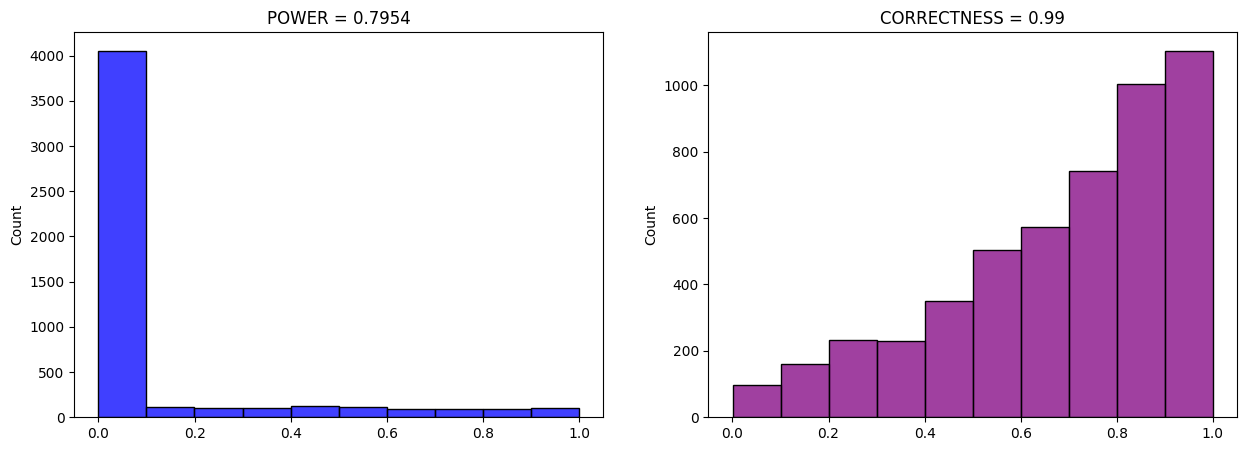

In [114]:
# total_dur - децильный метод - преобразование Бокса-Кокса - t-тест с корректировкой Бенджамини-Хохберга

from statsmodels.sandbox.stats.multicomp import multipletests 

deciles = np.quantile(np.array(sim['total_dur']), np.arange(0.2, 1, 0.2))

effect = []
power = []
correctness = []

for i in tqdm(range(1000)):

  groups = groups_splitter(sim.copy(), user_salt=salt_generator())
  df = pd.merge(sim, groups, how="left", on=['user_id']).drop_duplicates()

  effect_d = []
  power_d = []
  correctness_d = []

  for d in range(0, len(deciles)+1):

    if d == 0:
      a = df[(df['group'] == 'A') & (df['total_dur'] <= deciles[d])]['total_dur']
      b = df[(df['group'] == 'B') & (df['total_dur'] <= deciles[d])]['total_dur']
    elif d == len(deciles):
      a = df[(df['group'] == 'A') & (df['total_dur'] > deciles[d-1])]['total_dur']
      b = df[(df['group'] == 'B') & (df['total_dur'] > deciles[d-1])]['total_dur']
    else:
      a = df[(df['group'] == 'A') & (df['total_dur'] > deciles[d-1]) & (df['total_dur'] <= deciles[d])]['total_dur']
      b = df[(df['group'] == 'B') & (df['total_dur'] > deciles[d-1]) & (df['total_dur'] <= deciles[d])]['total_dur']
      
    b_effect = b * 1.02
  
    effect_d.append((b_effect.mean() - a.mean()) / a.mean())
    power_d.append(stats.ttest_ind(stats.boxcox(a + 1, lmbda=stats.boxcox(a + 1)[1]), stats.boxcox(b_effect + 1, lmbda=stats.boxcox(a + 1)[1]))[1])
    correctness_d.append(stats.ttest_ind(stats.boxcox(a + 1, lmbda=stats.boxcox(a + 1)[1]), stats.boxcox(b + 1, lmbda=stats.boxcox(a + 1)[1]))[1])
    
  effect.append(np.array(effect_d).mean()) 
  power.extend(multipletests(np.array(power_d), alpha = 0.05, method = 'fdr_bh')[1])
  correctness.extend(multipletests(np.array(correctness_d), alpha = 0.05, method = 'fdr_bh')[1])
      
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')

100%|██████████| 1000/1000 [27:26<00:00,  1.65s/it]


Effect = 2.01%


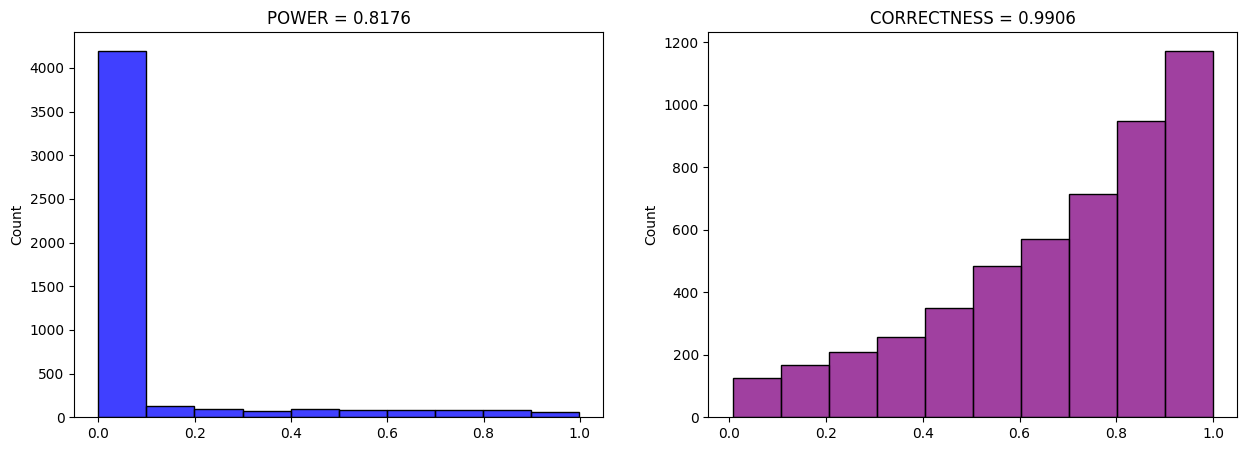

In [115]:
# total_dur - децильный метод - тест Манна-Уитни с корректировкой Бенджамини-Хохберга

from statsmodels.sandbox.stats.multicomp import multipletests 

deciles = np.quantile(np.array(sim['total_dur']), np.arange(0.2, 1, 0.2))

effect = []
power = []
correctness = []

for i in tqdm(range(1000)):

  groups = groups_splitter(sim.copy(), user_salt=salt_generator())
  df = pd.merge(sim, groups, how="left", on=['user_id']).drop_duplicates()

  effect_d = []
  power_d = []
  correctness_d = []

  for d in range(0, len(deciles)+1):

    if d == 0:
      a = df[(df['group'] == 'A') & (df['total_dur'] <= deciles[d])]['total_dur']
      b = df[(df['group'] == 'B') & (df['total_dur'] <= deciles[d])]['total_dur']
    elif d == len(deciles):
      a = df[(df['group'] == 'A') & (df['total_dur'] > deciles[d-1])]['total_dur']
      b = df[(df['group'] == 'B') & (df['total_dur'] > deciles[d-1])]['total_dur']
    else:
      a = df[(df['group'] == 'A') & (df['total_dur'] > deciles[d-1]) & (df['total_dur'] <= deciles[d])]['total_dur']
      b = df[(df['group'] == 'B') & (df['total_dur'] > deciles[d-1]) & (df['total_dur'] <= deciles[d])]['total_dur']
      
    b_effect = b * 1.02
  
    effect_d.append((b_effect.mean() - a.mean()) / a.mean())
    power_d.append(stats.mannwhitneyu(a, b_effect)[1])
    correctness_d.append(stats.mannwhitneyu(a, b)[1])
    
  effect.append(np.array(effect_d).mean()) 
  power.extend(multipletests(np.array(power_d), alpha = 0.05, method = 'fdr_bh')[1])
  correctness.extend(multipletests(np.array(correctness_d), alpha = 0.05, method = 'fdr_bh')[1])
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')

### Улучшения `quantity`

#### Стратификация

In [118]:
# Найдём, по скольки пользователям у нас есть информация.

wanted_users = sim.user_id.unique()
print(users[users.user_id.isin(wanted_users)].user_id.nunique())
print(round(users[users.user_id.isin(wanted_users)].user_id.nunique() / len(sim), 2))

174631
0.8


Далеко не все. Но попробуем с этим поработать.

In [119]:
sims = pd.merge(sim, users, on=['user_id'], how='left')

In [120]:
sims['strats'] = sims.sex + '+' + sims.kids_flg.astype(str)
sims.strats = sims.strats.replace(np.nan, 'unknown')

In [121]:
def poststrat(df, feature, strats, hue):
  n = df[hue].nunique()
  weights = {}
  for i in range(0, df[strats].nunique()):
    key = df[strats].value_counts().index[i]
    weights[key] = df[strats].value_counts()[i] / n

  df_mean = 0
  df_var = 0
  for i in weights:
    df_mean += df[df[strats] == i][feature].mean() * weights[i]
    df_var += df[df[strats] == i][feature].var() * weights[i]

  df_std = np.sqrt(df_var)
  df_n = len(df)

  return df_mean, df_std, df_n

100%|██████████| 1000/1000 [36:00<00:00,  2.16s/it]


Effect = 2.01%

СРЕДНЯЯ МЕТРИК: 
Группа A: 2.757, Группа B: 2.758 
СРЕДНЯЯ POSTSTRAT МЕТРИК: 
Группа A: 2.757, Группа B: 2.758 

ДИСПЕРСИЯ МЕТРИК: 
Группа A: 16.25281, Группа B: 16.26107 
ДИСПЕРСИЯ POSTSTRAT МЕТРИК: 
Группа A: 16.24578, Группа B: 16.25401 
ПОЛНОЕ СОВПАДЕНИЕ ДИСПЕРСИЙ POSTSTRAT И ИСХОДНЫХ МЕТРИК: 
Группа A: 0.0 случаев, Группа B: 0.0 случаев 



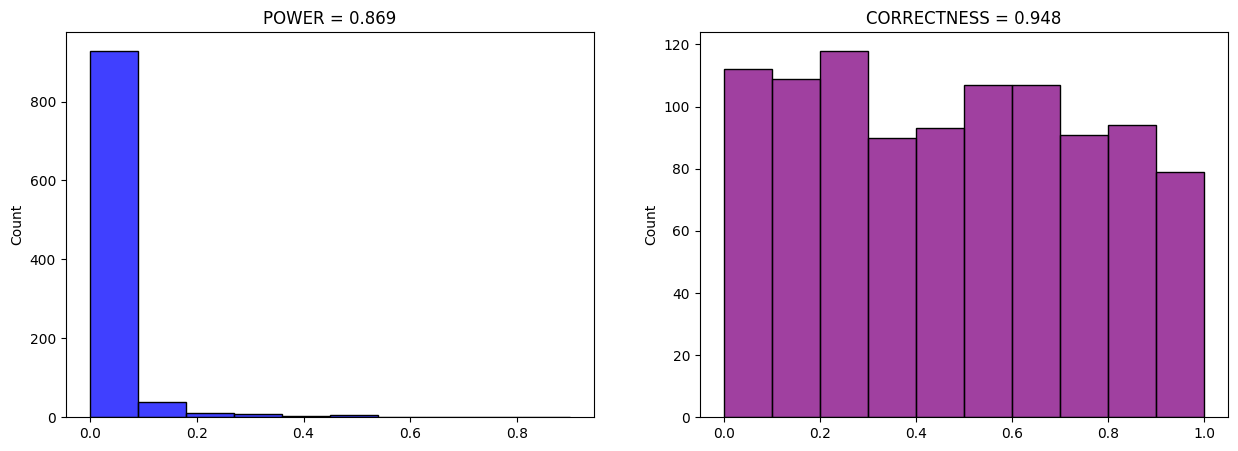

In [30]:
# quantity - постстратификация - t-тест

effect = []
power = []
correctness = []

a_mean = []
b_mean = []

a_strat_mean = []
b_strat_mean = []

a_var = []
b_var = []

a_strat_var = []
b_strat_var = []

a_var_diff = []
b_var_diff = []

for i in tqdm(range(1000)):
    
    groups = groups_splitter(sims.copy(), user_salt=salt_generator())
    df = pd.merge(sims, groups, how="left", on=['user_id']).drop_duplicates()
    
    a = df[df['group'] == 'A']
    a_strat_stats = poststrat(a, 'quantity', 'strats', 'user_id')
    a = a.quantity


    b = df[df['group'] == 'B']
    b_strat_stats = poststrat(b, 'quantity', 'strats', 'user_id')
    b_values = b.quantity

    b_effect = b_values * 1.02

    b_effect_df = b.drop(columns=['quantity'])
    b_effect_df['quantity'] = list(b_effect)
    b_effect_strat_stats = poststrat(b_effect_df, 'quantity', 'strats', 'user_id')
    b = b_values
    
    effect.append((b_effect.mean() - a.mean()) / a.mean())

    p_power, p_cor = stats.ttest_ind_from_stats(*a_strat_stats, *b_effect_strat_stats)[1], stats.ttest_ind_from_stats(*a_strat_stats, *b_strat_stats)[1]
    power.append(p_power)
    correctness.append(p_cor)
    

    a_mean.append(a.mean())
    b_mean.append(b.mean())

    a_strat_mean.append(a_strat_stats[0])
    b_strat_mean.append(b_strat_stats[0])

    a_var.append(a.var())
    b_var.append(b.var())

    a_strat_var.append(a_strat_stats[1] ** 2)
    b_strat_var.append(b_strat_stats[1] ** 2)

    a_var_diff.append(a_strat_var == a_var)
    b_var_diff.append(b_strat_var == b_var)
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')
print()
print('СРЕДНЯЯ МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
СРЕДНЯЯ POSTSTRAT МЕТРИК: \nГруппа A: {}, Группа B: {} \n\n\
ДИСПЕРСИЯ МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
ДИСПЕРСИЯ POSTSTRAT МЕТРИК: \nГруппа A: {}, Группа B: {} \n\
ПОЛНОЕ СОВПАДЕНИЕ ДИСПЕРСИЙ POSTSTRAT И ИСХОДНЫХ МЕТРИК: \nГруппа A: {} случаев, Группа B: {} случаев \n'.format
     (
      round(np.array(a_mean).mean(), 3), round(np.array(b_mean).mean(), 3),
      round(np.array(a_strat_mean).mean(), 3), round(np.array(b_strat_mean).mean(), 3),
      round(np.array(a_var).mean(), 5), round(np.array(b_var).mean(), 5),
      round(np.array(a_strat_var).mean(), 5), round(np.array(b_strat_var).mean(), 5),
      round(sum(a_var_diff) / len(a_var_diff), 3), round(sum(b_var_diff) / len(b_var_diff), 3)
     ))

#### Ранговая трансформация

In [122]:
def df_ranker(a, b, metric):
    df = pd.concat([a, b], axis = 0)
    df['rank'] = df[metric].rank()
    return df

100%|██████████| 1000/1000 [19:43<00:00,  1.18s/it]


Effect = 1.98%


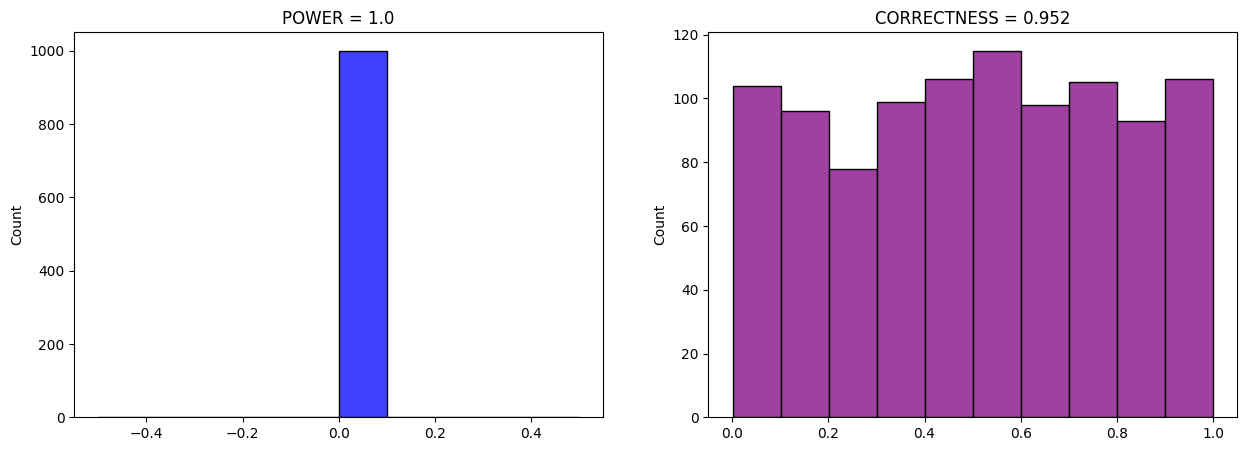

In [32]:
# quantity - ранговая трансформация - t-тест

effect = []
power = []
correctness = []

for i in tqdm(range(1000)):
    
    groups = groups_splitter(sim.copy(), user_salt=salt_generator())
    df = pd.merge(sim, groups, how="left", on=['user_id']).drop_duplicates()
    
    a = df[df['group'] == 'A']['quantity']
    b = df[df['group'] == 'B']['quantity']
    b_effect = b * 1.02
    
    effect.append((b_effect.mean() - a.mean()) / a.mean())
    
    df_ranked = df_ranker(df[df.group == 'A'], df[df.group == 'B'], 'quantity')
    a_ranks = df_ranked[(df_ranked['group'] == 'A')]['rank']
    b_ranks = df_ranked[(df_ranked['group'] == 'B')]['rank']
    
    df_b = df[df.group == 'B'].drop(columns=['quantity'])
    df_b['quantity'] = list(b_effect)
    
    df_effect_ranked = df_ranker(df[df.group == 'A'], df_b, 'quantity')
    a_ranks_effect = df_effect_ranked[(df_ranked['group'] == 'A')]['rank']
    b_effect_ranks = df_effect_ranked[(df_ranked['group'] == 'B')]['rank']

    p_power, p_cor = stats.ttest_ind(a_ranks_effect, b_effect_ranks)[1], stats.ttest_ind(a_ranks, b_ranks)[1]
    power.append(p_power)
    correctness.append(p_cor)
    
power = np.array(power)
correctness = np.array(correctness)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=power, bins=10, color='blue', ax=ax[0])
ax[0].set_title(f'POWER = {power[power < 0.05].shape[0] / power.shape[0]}')

sns.histplot(data=correctness, bins=10, color='purple', ax=ax[1])
ax[1].set_title(f'CORRECTNESS = {1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])}')

print(f'Effect = {round(np.array(effect).mean() * 100, 2)}%')

**Выводы**

Итого у нас 5 вариантов метрики:
1. `total_dur` с разбивкой на 0.2 квантили с нормализацией и параметрическим тестом - наиболее предпочтительный, хоть и наименее мощный вариант.
2. `total_dur` с разбивкой на 0.2 квантили с ранговым тестом - вариант второго порядка.
3. `quantity` с ранговой трансформацией и t-тестом - должен поймать самый слабый эффект и всё ещё информативен.
4. `quantity` с постстратификацией и t-тестом - попробуем ради интереса. Очень зависит от того, по какому проценту пользователей у нас будет информация.
5. `watched_pct` с t-тестом - тоже можно, но на него ориентируемся в последнюю очередь.

# Эксперимент

## Создание датасета и наложение эффекта

In [123]:
# Возьмём нужные 2 недели.

interactions.last_watch_dt = pd.to_datetime(interactions.last_watch_dt)

inter_exp = interactions[(interactions.last_watch_dt >= pd.to_datetime('2021-08-01'))
              & (interactions.last_watch_dt <= pd.to_datetime('2021-08-14'))]

In [259]:
# Сагрегируем датасет и дропнем то, что не войдёт в агрегацию.

exp = inter_exp.drop(['last_watch_dt', 'item_id'], axis=1)

exp = exp.groupby('user_id', as_index=False).agg(
    quantity=('total_dur', 'count'),
    total_dur=('total_dur', np.sum),
    watched_pct=('watched_pct', np.mean))

exp.loc[exp.query('total_dur == 0').index, 'quantity'] = 0

In [125]:
exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252140 entries, 0 to 252139
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      252140 non-null  int64  
 1   quantity     252140 non-null  int64  
 2   total_dur    252140 non-null  int64  
 3   watched_pct  252140 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 7.7 MB


Эксперимент затронул 252140 уникальных пользователей.

In [260]:
# Разобьём датасет на группы.

groups = groups_splitter(exp.copy(), user_salt='kiontestmodel20210114')
df = pd.merge(exp, groups, how="left", on=['user_id']).drop_duplicates()

In [277]:
# Поделим на децили.

deciles = np.quantile(np.array(df['total_dur']), np.arange(0.1, 1, 0.1))

In [278]:
# Поищем уже существующий эффект.

effect = []

for d in range(0, len(deciles)+1):

  if d == 0:
    a = df[(df['group'] == 'A') & (df['total_dur'] <= deciles[d])]['total_dur']
    b = df[(df['group'] == 'B') & (df['total_dur'] <= deciles[d])]['total_dur']
  elif d == len(deciles):
    a = df[(df['group'] == 'A') & (df['total_dur'] > deciles[d-1])]['total_dur']
    b = df[(df['group'] == 'B') & (df['total_dur'] > deciles[d-1])]['total_dur']
  else:
    a = df[(df['group'] == 'A') & (df['total_dur'] > deciles[d-1]) & (df['total_dur'] <= deciles[d])]['total_dur']
    b = df[(df['group'] == 'B') & (df['total_dur'] > deciles[d-1]) & (df['total_dur'] <= deciles[d])]['total_dur']

  if a.mean() == 0:
    effect.append(0)
  else:
    effect.append(np.round((b.mean() - a.mean()) / a.mean(), 3))

print(f'Эффект по децилям: {effect}')

Эффект по децилям: [0, 0.004, -0.001, -0.0, 0.001, -0.001, 0.003, 0.001, 0.004, 0.037]


In [276]:
a = df[df['group'] == 'A']['total_dur']
b = df[df['group'] == 'B']['total_dur']

np.round((b.mean() - a.mean()) / a.mean(), 3)

0.025

Нам повезло: эффект есть, и именно такой, как нам надо! И он больше, чем MDE для метрики `total_dur`.

## Тестирование

In [268]:
# total_dur - децильный метод - преобразование Бокса-Кокса - t-тест с корректировкой Бенджамини-Хохберга

from statsmodels.sandbox.stats.multicomp import multipletests

deciles = np.quantile(np.array(df['total_dur']), np.arange(0.2, 1, 0.2))

p_d = []

for d in range(0, len(deciles)+1):
  if d == 0:
    a = df[(df['group'] == 'A') & (df['total_dur'] <= deciles[d])]['total_dur']
    b = df[(df['group'] == 'B') & (df['total_dur'] <= deciles[d])]['total_dur']
  elif d == len(deciles):
    a = df[(df['group'] == 'A') & (df['total_dur'] > deciles[d-1])]['total_dur']
    b = df[(df['group'] == 'B') & (df['total_dur'] > deciles[d-1])]['total_dur']
  else:
    a = df[(df['group'] == 'A') & (df['total_dur'] > deciles[d-1]) & (df['total_dur'] <= deciles[d])]['total_dur']
    b = df[(df['group'] == 'B') & (df['total_dur'] > deciles[d-1]) & (df['total_dur'] <= deciles[d])]['total_dur']

  p_d.append(stats.ttest_ind(stats.boxcox(a + 1, lmbda=stats.boxcox(a + 1)[1]), stats.boxcox(b + 1, lmbda=stats.boxcox(a + 1)[1]))[1])
    
multipletests(np.array(p_d), alpha = 0.05, method = 'fdr_bh')[1]

array([0.69771928, 0.44258774, 0.44258774, 0.97720902, 0.97720902])

In [269]:
# total_dur - децильный метод - тест Манна-Уитни с корректировкой Бенджамини-Хохберга

from statsmodels.sandbox.stats.multicomp import multipletests

deciles = np.quantile(np.array(df['total_dur']), np.arange(0.2, 1, 0.2))

p_d = []

for d in range(0, len(deciles)+1):
  if d == 0:
    a = df[(df['group'] == 'A') & (df['total_dur'] <= deciles[d])]['total_dur']
    b = df[(df['group'] == 'B') & (df['total_dur'] <= deciles[d])]['total_dur']
  elif d == len(deciles):
    a = df[(df['group'] == 'A') & (df['total_dur'] > deciles[d-1])]['total_dur']
    b = df[(df['group'] == 'B') & (df['total_dur'] > deciles[d-1])]['total_dur']
  else:
    a = df[(df['group'] == 'A') & (df['total_dur'] > deciles[d-1]) & (df['total_dur'] <= deciles[d])]['total_dur']
    b = df[(df['group'] == 'B') & (df['total_dur'] > deciles[d-1]) & (df['total_dur'] <= deciles[d])]['total_dur']

  p_d.append(stats.mannwhitneyu(a, b)[1])
    
multipletests(np.array(p_d), alpha = 0.05, method = 'fdr_bh')[1]

array([0.81071554, 0.43392358, 0.43392358, 0.96543058, 0.96543058])

Оба теста на метрику `total_dur` оказались нечувствительны к изменениям.

In [296]:
# Найдём эффект по метрике quantity

a = df[df['group'] == 'A']['quantity']
b = df[df['group'] == 'B']['quantity']

np.round((b.mean() - a.mean()) / a.mean(), 3)

0.004

Эффект `quantity` меньше MDE.

In [280]:
# quantity - ранговая трансформация - t-тест

a = df[df['group'] == 'A']['quantity']
b = df[df['group'] == 'B']['quantity']

df_ranked = df_ranker(df[df.group == 'A'], df[df.group == 'B'], 'quantity')
a_ranks = df_ranked[(df_ranked['group'] == 'A')]['rank']
b_ranks = df_ranked[(df_ranked['group'] == 'B')]['rank']

stats.ttest_ind(a_ranks, b_ranks)[1]

0.5121781918897095

Эффект не найден. Попробуем тест с постстратификацией.

In [281]:
# Найдём, по скольки пользователям у нас есть информация.

wanted_users = exp.user_id.unique()
print(users[users.user_id.isin(wanted_users)].user_id.nunique())
print(round(users[users.user_id.isin(wanted_users)].user_id.nunique() / len(exp), 2))

199170
0.79


Доля как на дизайне.

In [286]:
dfs = pd.merge(df, users, on=['user_id'], how='left')

In [287]:
dfs['strats'] = dfs.sex + '+' + dfs.kids_flg.astype(str)
dfs.strats = dfs.strats.replace(np.nan, 'unknown')

In [288]:
# quantity - постстратификация - t-тест

a = dfs[dfs['group'] == 'A']
a_strat_stats = poststrat(a, 'quantity', 'strats', 'user_id')

b = dfs[dfs['group'] == 'B']
b_strat_stats = poststrat(b, 'quantity', 'strats', 'user_id')

stats.ttest_ind_from_stats(*a_strat_stats, *b_strat_stats)[1]

0.5192118734466356

Оба теста на `quantity` не нашли различий между группами.

In [297]:
# Найдём эффект по метрике watched_pct

a = df[df['group'] == 'A']['watched_pct']
b = df[df['group'] == 'B']['watched_pct']

np.round((b.mean() - a.mean()) / a.mean(), 3)

0.009

Он больше MDE и vanilla тест показывал 100-процентную мощность.

In [293]:
# watched_pct - t-тест

a = df[df['group'] == 'A']['watched_pct']
b = df[df['group'] == 'B']['watched_pct']

stats.ttest_ind(a, b)[1]

0.016129806259451044

Эффект обнаружен.

**Выводы**
1. Сложное распределение эффекта и недостаточная мощность не позволили тестам на `total_dur` обнаружить эффект.
2. Создание "запасных" тестов на других метриках - опасная практика. Тем более если не была проверена корреляция между основной метрикой и прокси. Нужно дизайниться либо подо что-то одно, либо под хорошо коррелирующие метрики.
3. Даже высокая мощность не позволила найти эффект меньше MDE на метрике `quantity`.
4. Только 100-процентная мощность и эффект выше MDE позволили сработать тесту на `watched_pct`. Но это чистая случайность.
5. Эксперимент можно считать неудачным.